In [19]:
### Run this cell before continuing
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)
source("tests.R")
source("cleanup.R")

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'tests.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [20]:

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

download.file(url, destfile = "winequality-white.csv")
white_wine <- read_delim("winequality-white.csv", delim = ";")
white_wine
     

Rows: 4898 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.5,0.24,0.19,1.2,0.041,30,111,0.99254,2.99,0.46,9.4,6
5.5,0.29,0.30,1.1,0.022,20,110,0.98869,3.34,0.38,12.8,7
6.0,0.21,0.38,0.8,0.020,22,98,0.98941,3.26,0.32,11.8,6


In [21]:
cortez <- as_tibble (white_wine |>
        select(sulphates, alcohol, quality))
cortez

sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>
0.45,8.8,6
0.49,9.5,6
0.44,10.1,6
⋮,⋮,⋮
0.46,9.4,6
0.38,12.8,7
0.32,11.8,6


In [22]:
##Split the data into training and test set

cortez_split <- initial_split(cortez, prop = 0.75, strata = quality)
cortez_training <- training(cortez_split)
cortez_testing <- testing(cortez_split)

cortez_training

sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>
0.56,12.0,5
0.53,9.7,5
0.67,9.7,5
⋮,⋮,⋮
0.50,13.30,7
0.59,11.60,7
1.08,12.15,7


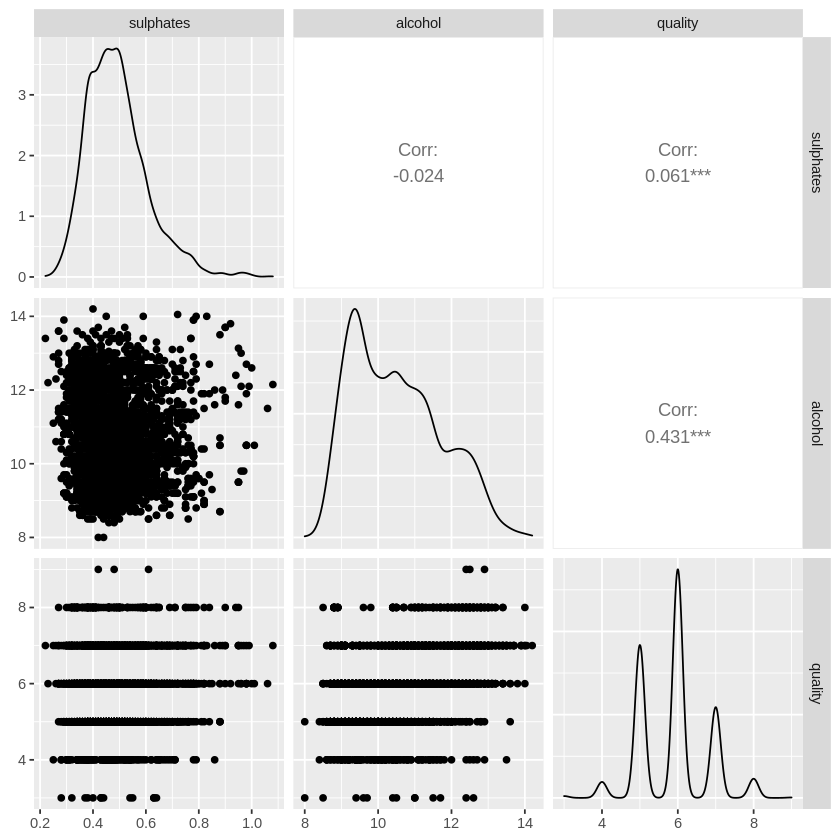

In [23]:
cortez_eda <- cortez_training |>
ggpairs()
cortez_eda

In [25]:
## Create the model specification for linear regression
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

print(lm_spec)

Linear Regression Model Specification (regression)

Computational engine: lm 



In [26]:
##Create the recipe using the training data
cortez_recipe <- recipe(quality ~ alcohol + sulphates, data = cortez_training)

print(cortez_recipe)

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2


In [14]:
## Use workflow() to fit/build the model on the training data

cortez_fit <- workflow() |>
  add_recipe(cortez_recipe) |>
  add_model(lm_spec) |>
  fit(data = cortez_training)
cortez_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)      alcohol    sulphates  
     2.3264       0.3138       0.5193  


In [30]:
# calculate the RMSE
lm_rmse <- cortez_fit |>
         predict(cortez_training) |>
         bind_cols(cortez_training) |>
         metrics(truth = quality, estimate = .pred) |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()
lm_rmse

[1] 0.7226999

In [31]:
# Use the model you built to make predictions on the test data and evaluate the accuracy

cortez_rec <- recipe(quality ~ sulphates + alcohol, data = cortez_training) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

cortez_vfold <- vfold_cv(cortez_training, v = 5, strata = quality)

gridvals <- tibble(neighbors = seq(1,10))

cortez_fit <- workflow() |>
  add_recipe(cortez_rec) |>
  add_model(knn_spec) |>
  tune_grid(cortez_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

cortez_k <- cortez_fit |>
filter(mean == min(mean))|>
pull(neighbors)

cortez_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = cortez_k) |>
  set_engine("kknn") |>
  set_mode("regression")

cortez_fit <- workflow() |>
  add_recipe(cortez_rec) |>
  add_model(cortez_spec) |>
  fit(data = cortez_training)

knn_rmspe <- cortez_fit |>
predict(cortez_testing) |>
bind_cols(cortez_testing) |>
metrics(truth = quality, estimate = .pred) |>
filter(.metric == "rmse") |>
select(.estimate) |>
pull()

knn_rmspe

[1] 0.7995356

`geom_smooth()` using formula 'y ~ x'



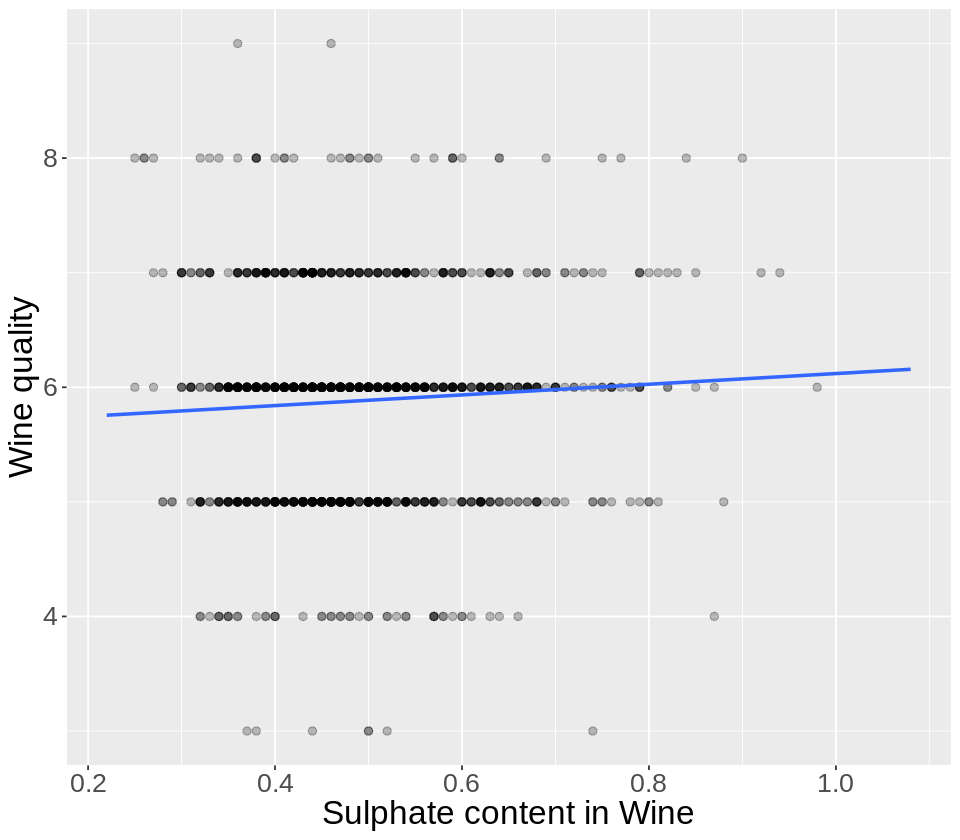

In [32]:
options(repr.plot.width = 8, repr.plot.height = 7)

lm_predictions_test_sulphates <- cortez_testing |>
     ggplot(aes(x = sulphates, y = quality)) +
         geom_point(alpha = 0.25, size = 2) +
         geom_smooth(data=cortez_training,aes(x= sulphates, y = quality),method = "lm", se = FALSE) +
         xlab("Sulphate content in Wine") +
         ylab("Wine quality") +
        theme(text = element_text(size = 20))
lm_predictions_test_sulphates

`geom_smooth()` using formula 'y ~ x'



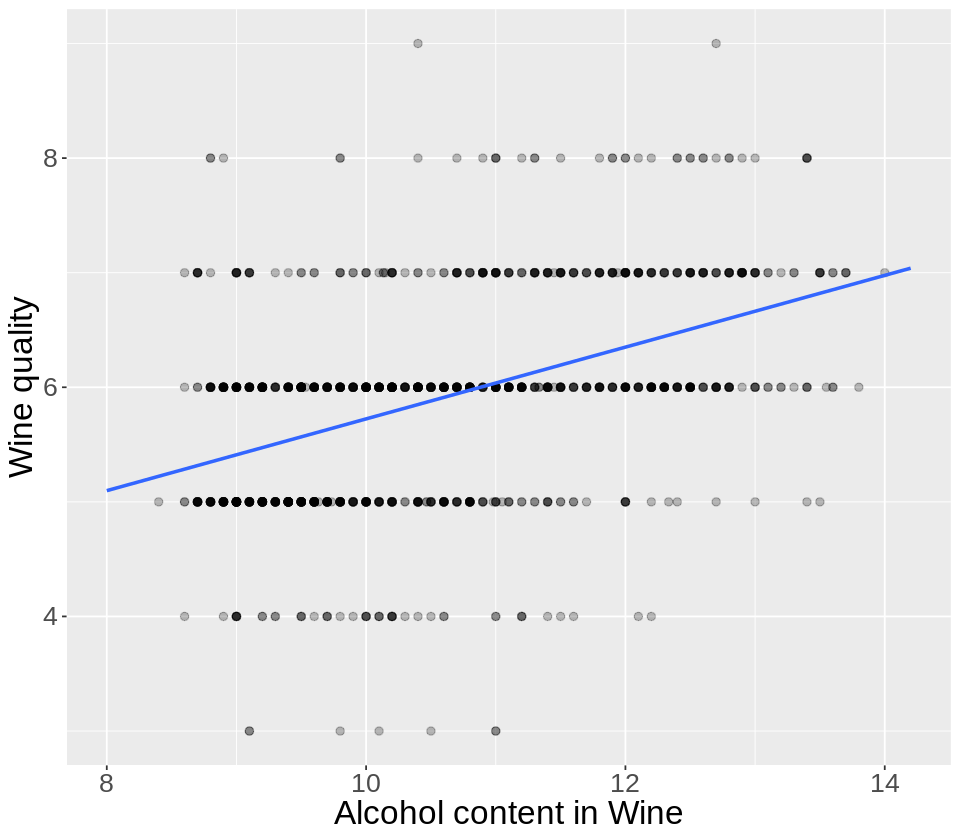

In [33]:
options(repr.plot.width = 8, repr.plot.height = 7)

lm_predictions_test_alcohol <- cortez_testing |>
     ggplot(aes(x = alcohol, y = quality)) +
         geom_point(alpha = 0.25, size = 2) +
         geom_smooth(data=cortez_training,aes(x= alcohol, y = quality),method = "lm", se = FALSE) +
         xlab("Alcohol content in Wine") +
         ylab("Wine quality") +
        theme(text = element_text(size = 20))
lm_predictions_test_alcohol